# 2D Convolution Astrophysical Data: A Tutorial

## Introduction
Convolution is a fundamental operation in many areas of science, including astrophysics, where it is mainly used to smooth data. In this tutorial, we will learn how to perform a 2D convolution on astrophysical data using Python and the Astropy library. This tutorial is aimed at undergraduate and graduate students with a background in astrophysics.

## Learning Objectives
1. Understand the principles of 2D (spatial) convolution.
2. Learn how to determine and construct a convolution kernel.
3. Apply convolution to astrophysical data using ``Astropy`` and ``SpectralCube``

## Background on 2D Convolution

### What is Convolution?
Convolution is a mathematical operation that combines two functions in a specific way. In the context of image processing, one function is the image, and the other is the kernel (or filter). The kernel is a small 2D matrix that is applied to the image to produce a smoothed or otherwise transformed version of the original image.

Mathematically, a (discrete) 2D convolution can be expressed as:
$$
(f * g)(x,y) := \sum_m\sum_n f\left(m,n\right)\cdot g\left(x-m,y-n\right)
$$
in this framework, we have:
* $f$ the original image (with pixel coordinates $x$ and $y$)
* $g$ the kernel matrix
*  $*$ the convolution operation

### How to chose the convolution kernel $g$

A convolution kernel is a small matrix used to apply effects such as blurring, sharpening, or edge detection to an image. In this tutorial, and generally in the context of astrophysical image homogenization, we'll focus on a smoothing kernel, specifically a Gaussian kernel, which is commonly used to reduce noise and detail in an image. 

A 2D Gaussian kernel is defined by the Gaussian function:
$$
G(x,y)=\frac{1}{2\pi \sigma^2}\cdot \exp{\left(⁡−\frac{x^2+y^2}{\sigma^2}\right)}
$$
Where $\sigma$ is the standard deviation of the Gaussian distribution. **The challenge in constructing such a kernel is determining the right value for $\sigma$, which depends on the input image and the targeted resolution you want to smooth your map to.** 

There exist also more sophisticated 2D kernels that take into acount also second order effects of the point-spread-function. A more detailed explanation and list of such kernels can be found [here](https://www.astro.princeton.edu/~draine/Kernels.html).

## Step 1: Download example data

For illustration purposes, we first download a example image.

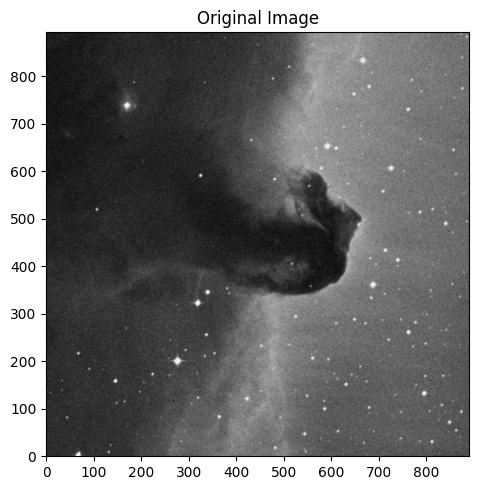

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.utils.data import download_file
from astropy.wcs import WCS, utils
from astropy.visualization.wcsaxes import add_beam, add_scalebar
from astropy import units as u


# Load the sample data
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )
hdu = fits.open(image_file)[0]
image_data = hdu.data

# Display the original image
plt.figure(figsize=(5, 5))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.title('Original Image')
plt.tight_layout()
plt.show()

## Step 2: Generate the Gaussian 2D kernel

We can use the `Gaussian2DKernel` to generate a kernel. We will see later how we can determine the right value for the width of the kernel (the `sigma`).

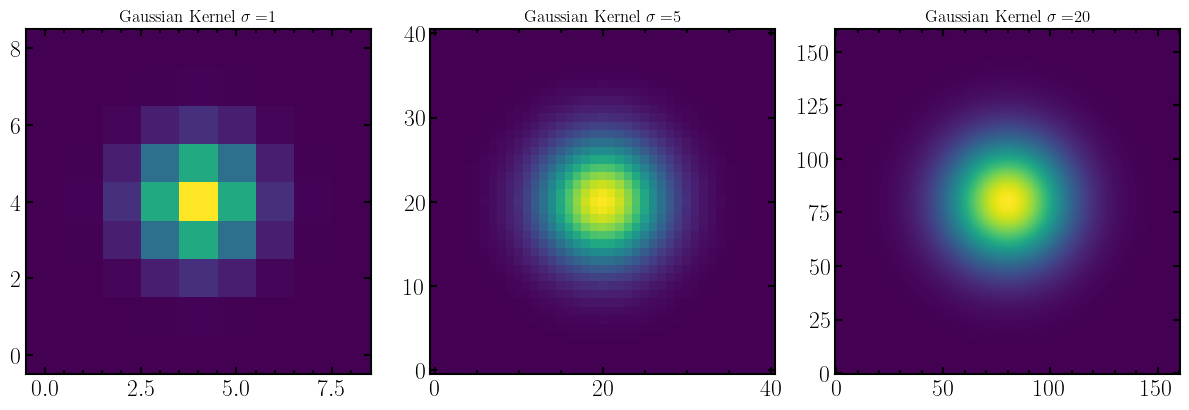

In [6]:
# Define the standard deviation (sigma) of the Gaussian

# Create the Gaussian kernel
# We define here the width of the gaussian kernel
sigmas = [1,5,20]

# we store the kernels in a dictionary to access them later 
gaussian_kernels={}
# Display the kernel
plt.figure(figsize=(12, 4))

for i, sigma in enumerate(sigmas):
    ax = plt.subplot(1,3,i+1)
    gaussian_kernel = Gaussian2DKernel(x_stddev=sigma)
    gaussian_kernels[str(sigma)]=gaussian_kernel
    plt.imshow(gaussian_kernel.array, cmap='viridis', origin='lower')
    plt.title(r'Gaussian Kernel $\sigma = $'+str(int(sigma)))

plt.tight_layout()
plt.show()

## Step 3: Apply the Convolution using the build-in astropy function

We can apply the convolution (smoothing) of the data using the `astropy.convolve` function. This function treats `nan`s differently than the `scipy.convolve` function in the sense that it can interpolate between points. 

**Note:** For larger images, instead of `convolve`, one could also use the faster `convolve_fft` function: 

```smoothed_image = convolve_fft(image_data, gaussian_kernel)```

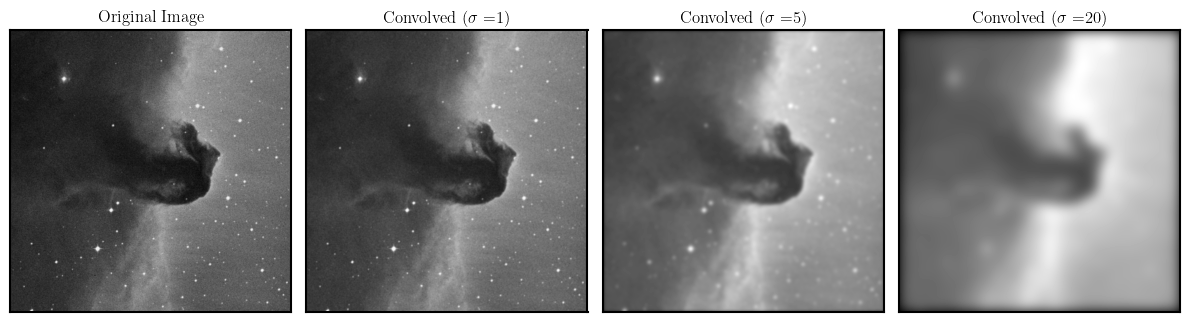

In [8]:
plt.figure(figsize=(12, 4))

ax = plt.subplot(1,4,1)
plt.imshow(image_data, cmap='gray', origin='lower')
plt.title('Original Image')
ax.set_yticks([])
ax.set_xticks([])
for i, sigma in enumerate(sigmas):
    ax = plt.subplot(1,4,i+2)
    gaussian_kernel = gaussian_kernels[str(sigma)]
    smoothed_image = convolve(image_data, gaussian_kernel)
    plt.imshow(smoothed_image, cmap='gray', origin='lower')
    plt.title(r'Convolved ($\sigma = $'+str(int(sigma))+')')
    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()

## Conlcuding remark
This concludes the process of convolution. If we are working with a 3D datacube, then we apply the convolution to each channel (i.e. we iterate over the spectral axis) and construct the final, spatially convolved data cube in this way.

# Calculating the correct value for kernel width

In astronomy, a common challenge we encounter when we want to convolve a dataset from a given angular resolution, $\theta_{\rm input}$, to a desired resolution, $\theta_{\rm target}$, is determining the width of the Gaussian kernel, $\theta_{\rm kernel}$. To determine the width, we simply can calculate:
$$
\theta_{\rm kernel} = \sqrt{\theta_{\rm target}^2-\theta_{\rm input}^2}
$$

**Note:** Here, we assume, as simplification, that the beam of the observations is symmetric (i.e. circular). When working with interferommetric data, the beam often is rather described by a rotated ellipse rather than a circle (see [radio-beam.readthedocs.io](radio-beam.readthedocs.io)).

## Illustrating the Challenge

We work here with IRAM 30m CO(2-1) data of the nearby grand-design spiral galaxy M51. The challenge is that the native angular resolution of the observations is at ${\sim}13''$. We have additional date at 33" resolution to which we wish to compare our CO(2-1) observations, so we need to convolve the IRAM 30m data to the required resolution (see illustration below)

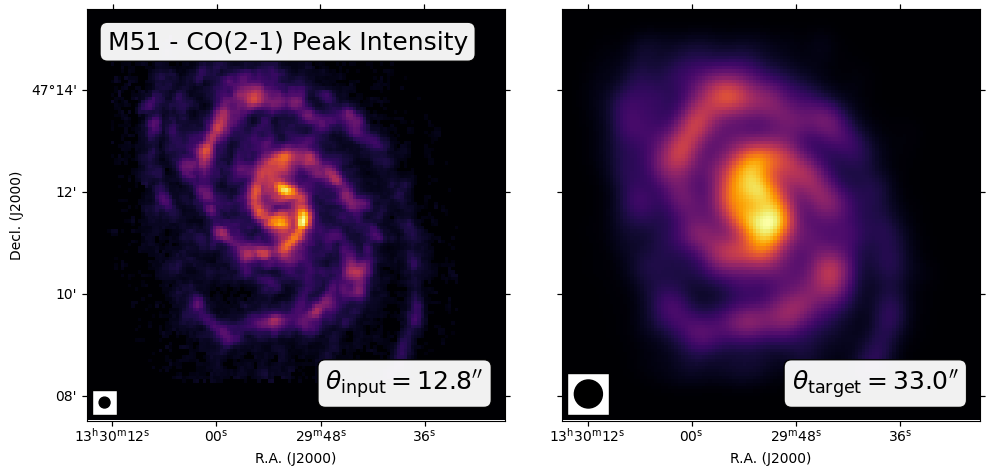

In [34]:
plt.figure(figsize=(10,5))
props = dict(boxstyle='round', facecolor='w', alpha=0.95)

hdu = fits.open('./data/ngc5194_co21_tpeak.fits')[0]
wcs = WCS(hdu.header)

ax = plt.subplot(1,2,1,projection=wcs)
plt.imshow(hdu.data,  origin='lower', cmap='inferno')
ax.set_xlabel('R.A. (J2000)')
ax.set_ylabel('Decl. (J2000)')

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, 'M51 - CO(2-1) Peak Intensity', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

ax.text(0.95, 0.05, r'$\theta_{\rm input} =$'+'%.1f'%(hdu.header['BMAJ']*3600)+r'$^{\prime \prime}$', transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', ha='right', bbox=props)

#illustrate the beam
add_beam(ax, major=hdu.header['BMAJ']*u.deg, minor=hdu.header['BMIN']*u.deg, angle=hdu.header['BPA']*u.deg, frame=True, color='k')




hdu = fits.open('./data/ngc5194_co21_tpeak_33as.fits')[0]
wcs = WCS(hdu.header)

ax = plt.subplot(1,2,2,projection=wcs)
plt.imshow(hdu.data,  origin='lower', cmap='inferno')
ax.set_xlabel('R.A. (J2000)')
ax.text(0.95, 0.05, r'$\theta_{\rm target} =$'+'%.1f'%(hdu.header['BMAJ']*3600)+r'$^{\prime \prime}$', transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', ha='right', bbox=props)
#illustrate the beam
add_beam(ax, major=hdu.header['BMAJ']*u.deg, minor=hdu.header['BMIN']*u.deg, angle=hdu.header['BPA']*u.deg, frame=True, color='k')


lon = ax.coords[0]
lat = ax.coords[1]
lat.set_ticklabel_visible(False)
plt.tight_layout()


## Step 1: Calculating the desired 2D gaussian width 

In [37]:
hdu = fits.open('./data/ngc5194_co21_tpeak.fits')[0]

#the beam major and minor axes are generallly defined in degrees, therefore, we convert to arcseconds:
theta_input = hdu.header['BMAJ']*3600 # in arcsec
theta_target = 33 # in arcsec

theta_kernel_arcsec = np.sqrt(theta_target**2-theta_input**2)

#Note: check if this is a reasonable number. If not, then your hdu.header['BMAJ'] might not have been defined in units of degree. 
print('theta_kernel = %.2f arcsec'%theta_kernel_arcsec)

theta_kernel = 30.41 arcsec


**Note** This value here corresponds to the FWHM of the beam in arcsec, we need to convert this value to a Gaussian width, and we need to convert in terms of pixels (using the pixel width of the input image)

In [38]:
#This again assumes that the pixel dimensions are provided in degrees, which is usually the standard.
pixel_scale = utils.proj_plane_pixel_scales(wcs)*u.deg
pixel_width_arcsec = pixel_scale[0].to(u.arcsec).value

fwhm2sigma = 2*np.sqrt(2*np.log(2))
sigma_kernel = (theta_kernel_arcsec/pixel_width_arcsec)/fwhm2sigma

print('sigma_kernel = %.2f pixel'%sigma_kernel)

sigma_kernel = 3.23 pixel


## Step 2: Applying the convolution

In [39]:
#step 2.1: Compute the 2D kernel
gaussian_kernel = Gaussian2DKernel(x_stddev=sigma_kernel)

In [40]:
#step 2.2: Compute the convolution with the kernel from the previous step
smoothed_image = convolve(hdu.data, gaussian_kernel, normalize_kernel=True,)

## Illustrating the Convolved Image:

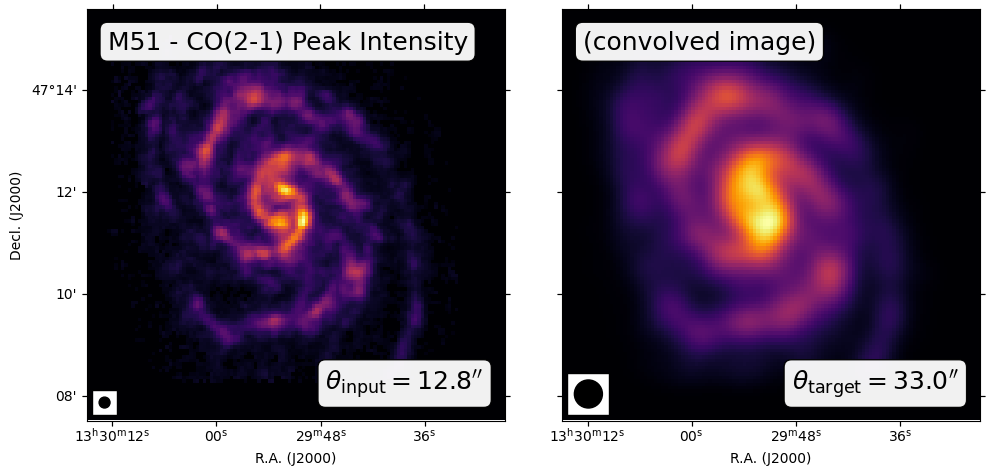

In [41]:
plt.figure(figsize=(10,5))
props = dict(boxstyle='round', facecolor='w', alpha=0.95)

wcs = WCS(hdu.header)

ax = plt.subplot(1,2,1,projection=wcs)
plt.imshow(hdu.data,  origin='lower', cmap='inferno')
ax.set_xlabel('R.A. (J2000)')
ax.set_ylabel('Decl. (J2000)')

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, 'M51 - CO(2-1) Peak Intensity', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

ax.text(0.95, 0.05, r'$\theta_{\rm input} =$'+'%.1f'%(hdu.header['BMAJ']*3600)+r'$^{\prime \prime}$', transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', ha='right', bbox=props)
#illustrate the beam
add_beam(ax, major=hdu.header['BMAJ']*u.deg, minor=hdu.header['BMIN']*u.deg, angle=hdu.header['BPA']*u.deg, frame=True, color='k')


ax = plt.subplot(1,2,2,projection=wcs)
plt.imshow(smoothed_image,  origin='lower', cmap='inferno')
ax.set_xlabel('R.A. (J2000)')
ax.text(0.95, 0.05, r'$\theta_{\rm target} =$'+'%.1f'%(theta_target)+r'$^{\prime \prime}$', transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', ha='right', bbox=props)
ax.text(0.05, 0.95, '(convolved image)', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)
#illustrate the beam
add_beam(ax, major=theta_target*u.arcsec, minor=theta_target*u.arcsec, angle=0, frame=True, color='k')


lon = ax.coords[0]
lat = ax.coords[1]
lat.set_ticklabel_visible(False)
plt.tight_layout()


# Convolving 3D data cubes with `spectralcube`

In particular when dealing with 3D data cubes, instead of constructing a for-loop that iterates and convolves the individual channels, it is far easier to use the built in functionalities of the `spectralcube` package. The description of the smoothing process is described [here](https://spectral-cube.readthedocs.io/en/latest/smoothing.html). The following provides a quick  overview of how to set up the convolution to a user-defined resolution.

In [78]:
import radio_beam
from spectral_cube import SpectralCube
from astropy import units as u

We again will work with the M51 CO(2-1) data observed with the IRAM 30m telescope (this time the actual cube)

### Step 1: Load in the Data with spectral cube

In [82]:
cube = SpectralCube.read('./data/ngc5194_co21.fits')

### Step 2: define the target resolution

In [84]:
#in our case, we want to convolve to 33 arcsec
# since we define a circular beam, we only need to provide the major axes
beam = radio_beam.Beam(major=33*u.arcsec)

### Step 3: Use the built-in convolution function

**Note:** For large (>1GB) cubes, you might need to pass the following line first:

```cube.allow_huge_operations = True```

In [85]:
new_cube = cube.convolve_to(beam)

### Concluding remarks:
* The `new_cube` is a 3D data cube that now contains the smoothed data. You can save this to the disk using `new_cube.write('m51_co21_33as.fits')`
* If you have two cubes and you want to convolve one to the other angular resolution, you can also use the spectralcube the following way:

In [134]:
# cube_lowres = SpectralCube.read(...)
# cube_highres = SpectralCube.read(...)

# common_beam = cube_lowres.beams.common_beam()
# cube_highres_convolved = cube_highres.convolve_to(common_beam)

**Using spectraCube for 2D convolution**

The following example showcases how you can use Spectral Cube to convolve also 2D data:

In [31]:
from spectral_cube import Projection
from astropy.io import fits
from radio_beam import Beam
import astropy.units as u

img = Projection.from_hdu(fits.open('./data/ngc5194_co21_tpeak.fits'))
targ_beam = Beam(33*u.arcsec)
conv_img = img.convolve_to(targ_beam)